In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import numpy as np
import datetime as dt

%run Config.ipynb
%run Utils.ipynb
%run models.ipynb
%run Dataset_preparation.ipynb


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda


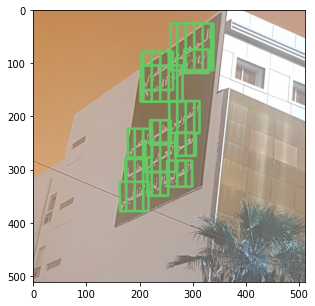

In [2]:
for b, (d, img, r, c, s) in enumerate(lo):
    d=d[0]
    fig=plt.figure(figsize=(5,5))
    plt.imshow(d)
    plt.show()
    break

In [3]:
def save_checkpoint(model_dict, extension = "pth"):
    path = os.path.join(checkpoints_dir,f'model_epoch{epoch+1:02d}.pth')
    
    try:
        torch.save(model_dict, path)
        print("Checkpoint saved successfully")
        
    except BaseException as e:
        print(e)
        print("Failed to save the file, try again !")

In [4]:
model=CTPN()
model.to(device)

CTPN(
  (base_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [5]:
epochs=20
alpha=1e-3
resume=-1
params=model.parameters()
optimizer=optim.SGD(params, alpha, 0.9, 0.0005)
#optimizer=optim.Adam(params, alpha, weight_decay=0.0005)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
graph_loss=[]
predicted=[]

if len(os.listdir(checkpoints_dir))!=0 :
    
    print('using pretrained weight: {}'.format(os.listdir(checkpoints_dir)[-1]))
    cc = torch.load(os.path.join(checkpoints_dir,os.listdir(checkpoints_dir)[-1]), map_location=device)
    model.load_state_dict(cc['model_state_dict'])
    resume=cc['epoch']
    print("Resuming from epoch: {}".format(resume+2))
    
    optimizer.load_state_dict(cc['optimizer_state_dict'])
    scheduler.load_state_dict(cc['scheduler_state_dict'])
    graph_loss=cc['graph_loss']
    predicted=cc['predicted']
    

using pretrained weight: model_epoch18.pth
Resuming from epoch: 19


In [6]:
closs=cls_loss(device)
rloss=regr_loss(device)
sloss=regr_loss(device)

for epoch in range(resume+1,epochs):
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print("="*50)
    
    epoch_size=len(dataset)//batch_size
    epoch_closs=0
    epoch_rloss=0
    epoch_sloss=0
    epoch_total_loss=0
    
    model.train()
    
    start=dt.datetime.now()
    for bat, (d, image, cls, regr, refine) in enumerate(lo):

        cls=cls.to(device)
        regr=regr.to(device)
        refine=refine.to(device)
        image=image.to(device)
        
        optimizer.zero_grad()
        
        output_cls, output_regr, output_refine=model(image)
        
        loss1=closs(output_cls,cls)
        loss2=rloss(output_regr,regr)
        loss3=rloss(output_refine,refine)
                
        total_loss=loss1+loss2+2*loss3
        
        total_loss.backward()
        optimizer.step()
        
        epoch_closs+=loss1.item()
        epoch_rloss+=loss2.item()
        epoch_sloss+=loss3.item()
        epoch_total_loss+=total_loss.item()
    
    scheduler.step()
    
    end=dt.datetime.now()
    print("Time elapsed in this epoch: {}".format(end-start))
    
    epoch_total_loss/=epoch_size
    epoch_closs/=epoch_size
    epoch_rloss/=epoch_size
    epoch_sloss/=epoch_size
    graph_loss.append(epoch_total_loss)

    print(f'Epoch loss: {epoch_total_loss}')
    print(f"Epoch cls_loss: {epoch_closs} regr_loss: {epoch_rloss} refine_loss: {epoch_sloss}")
    
              
    save_checkpoint({'model_state_dict':model.state_dict(),
                     'epoch':epoch,
                     'optimizer_state_dict':optimizer.state_dict(),
                     'scheduler_state_dict':scheduler.state_dict(),
                     'graph_loss':graph_loss,
                     'predicted':predicted
                 })
    print("="*50)
    

print("Training complete")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Epoch 19/20:
Time elapsed in this epoch: 0:09:17.037308
Epoch loss: 0.09057316264417023
Epoch cls_loss: 0.0326684788663988 regr_loss: 0.04709698569541797 refine_loss: 0.005403849013924628
Checkpoint saved successfully
Epoch 20/20:
Time elapsed in this epoch: 0:09:55.680734
Epoch loss: 0.08970487823244185
Epoch cls_loss: 0.031925737915677016 regr_loss: 0.04700345495995134 refine_loss: 0.005387842669128076
Checkpoint saved successfully
Training complete


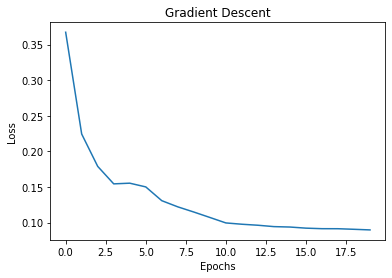

In [7]:
plt.plot(graph_loss)
plt.title("Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()